# MBTI Project - Feature Engineering & Preprocessing
<br>

<div class="span5 alert alert-info">
<h3>Introduction</h3>
    <p>This section comes after the <b>Exploratory Data Analysis (EDA)</b> step. In the following lines of code you will find the steps I took in terms of preprocessing the available data. What we want to achieve is actually a clean dataset that our machine learning models can analyze well. Our final goal is create a machine learning model that determines if we can classify MBTI types taking into consideration the posts made by each person.<p>
</div>

<div class="span5 alert alert-danger">

<h3>Disclaimer</h3>
    <p>The purpose of this notebook is to go over certain aspects of Natural Language Processing. There might be some parts of the notebook that do not have particular use for the future of this project but they are useful for learning purposes so I left them inside. I would also like to promote <b>An NLP workshop by Emmanuel Ameisen</b> his notebook was very helpful for the second part of this analysis. <p>
</div>

<br>

### Table of Contents

- [Summarized goals](#goals)
- [Importing Libraries](#importing)
- [Review of our Dataset](#review)
- [Feature Engineering](#nlp)
    - [NLP](#nlp)
    - [TextStat](#stats)
- [CountVectorizer](#count)
- [Word Clouds](#cloud)
- [TF-IDF](#tfidf)
- [Imbalanced Datasets](#imbalanced)
- [First steps into model creation](#model)
    - [Train Test Split](#train_test)
    - [Model with ContVectorizer](#cv)
    - [Model with TF-IDF](#tf)
    - [Model with Google's trained Word2Vec model](#wv)
    

<a id=goals></a>

## Summarized Goals
***

We will focus on **Feature Engineering**

[Maarten Grootendorst](https://towardsdatascience.com/4-tips-for-advanced-feature-engineering-and-preprocessing-ec11575c09ea) says "Arguably, two of the most important steps in developing a machine learning model is feature engineering and preprocessing. Feature engineering consists of the creation of features whereas preprocessing involves cleaning the data."

[Emre Rençberoğlu](https://towardsdatascience.com/@emrerencberoglu) says "Feature engineering efforts mainly have two goals:

- Preparing the proper input dataset, compatible with the machine learning algorithm requirements.
- Improving the performance of machine learning models."

<a id=importing></a>

## Imports
***

In [3]:
# data wrangiling libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.transforms
from matplotlib.patches import Patch
import seaborn as sns

%matplotlib inline
sns.set(rc={'axes.facecolor':'white'})

# natural language processing libraries
import nltk
import nltk.corpus 
import textstat

# other libraries
import os
import re
from tqdm import tqdm, tqdm_pandas
tqdm.pandas(desc="Progress!")
import time

In [2]:
df = pd.read_csv('../../data/mbti_interim.csv', index_col=0)

<a id=review></a>

<br>


## Reviewing our Dataset
***

In [4]:
df.columns

Index(['type', 'posts', 'I', 'J', 'N', 'T', 'NF', 'NT', 'SP', 'SJ',
       'posts_len', 'posts_separated', 'count_posts', 'avg_num_char_x_post',
       'num_of_links', ':D_count', ';D_count', ':)_count', ';)_count',
       ':(_count', 'xD_count', 'XD_count', 'total_emoticons',
       'avg_emoticons_per_post', 'INFJ_mentions', 'ENTP_mentions',
       'INTP_mentions', 'INTJ_mentions', 'ENTJ_mentions', 'ENFJ_mentions',
       'INFP_mentions', 'ENFP_mentions', 'ISFP_mentions', 'ISTP_mentions',
       'ISFJ_mentions', 'ISTJ_mentions', 'ESTP_mentions', 'ESFP_mentions',
       'ESTJ_mentions', 'ESFJ_mentions', 'total_mentions',
       'avg_mentions_per_post', 'I_count', 'me_count', 'my_count',
       'mine_count', 'myself_count', 'We_count', 'us_count', 'our_count',
       'ourselves_count', 'total_first_person', 'avg_first_person',
       'you_count', 'your_count', 'yours_count', 'yourself_count',
       'yourselves_count', 'total_second_person', 'avg_second_person',
       'he_count', 'him_

<br>

Let's go back a bit and keep the first ten columns for the time being. Those columns are the predictor variable (text) and the target variables (MBTI labels)

In [5]:
df = df.iloc[:,0:10]

In [6]:
df.columns

Index(['type', 'posts', 'I', 'J', 'N', 'T', 'NF', 'NT', 'SP', 'SJ'], dtype='object')

<a id=nlp></a>

<br>


## Feature Engineering - NLP
***

At the moment I am not sure if it is better to treat every posts separetly or to use all the posts as one large corpus. I will start by trying the latter way. I will follow the checklist for KDNuggets:

- Remove all irrelevant characters such as any non alphanumeric characters
- Tokenize your text by separating it into individual words
- Remove words that are not relevant, such as “@” twitter mentions or urls
- Convert all characters to lowercase, in order to treat words such as “hello”, “Hello”, and “HELLO” the same
- Consider combining misspelled or alternately spelled words to a single representation (e.g. “cool”/”kewl”/”cooool”)
- Consider lemmatization (reduce words such as “am”, “are”, and “is” to a common form such as “be”) 

Except the 5th point I will do all of the above and try to use the POS_tags as an additional practical learning

In [7]:
# regex remove hyperlinks
df['text_clean'] = df['posts'].str.replace('http\S+|www.\S+', '', case=False)

In [8]:
# Removing unwanted characters
df['text_clean'] = df['text_clean'].str.replace('[^a-zA-Z]', ' ') 

In [9]:
# Making everything lowercase
df['text_clean'] = df['text_clean'].str.lower() 

In [10]:
# tokenize each post
from nltk.tokenize import word_tokenize

df['text_clean'] = df['text_clean'].apply(lambda x: word_tokenize(x))

In [11]:
# lemmatize each word
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

df['text_clean'] = df['text_clean'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [12]:
# create parts of speech tags (https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
df['pos_tags'] = df['text_clean'].progress_apply(lambda x: [nltk.pos_tag(word_tokenize((y))) for y in x])

Progress!: 100%|██████████| 8675/8675 [1:18:27<00:00,  1.84it/s]   


In [13]:
df.head()

type                                              posts  I  J  N  T  NF  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...  1  1  1  0   1   
1  ENTP  'I'm finding the lack of me in these posts ver...  0  0  1  1   0   
2  INTP  'Good one  _____   https://www.youtube.com/wat...  1  0  1  1   0   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...  1  1  1  1   0   
4  ENTJ  'You're fired.|||That's another silly misconce...  0  1  1  1   0   

   NT  SP  SJ                                         text_clean  \
0   0   0   0  [and, intj, moment, sportscenter, not, top, te...   
1   1   0   0  [i, m, finding, the, lack, of, me, in, these, ...   
2   1   0   0  [good, one, course, to, which, i, say, i, know...   
3   1   0   0  [dear, intp, i, enjoyed, our, conversation, th...   
4   1   0   0  [you, re, fired, that, s, another, silly, misc...   

                                            pos_tags  
0  [[(and, CC)], [(intj, NN)], [(moment, NN)], [(...  
1  [[(i, NN)], [(m, NN)], [(finding, VBG)], [(the...  
2  [[(good, JJ)], [(one, CD)], [(course, NN)], [(...  
3  [[(dear, NN)], [(intp, NN)], [(i, NN)], [(enjo...  
4  [[(you, PRP)], [(re, NN)], [(fired, VBN)], [(t...

In [14]:
df.to_csv('../../data/mbti_nlp.csv')

<a id=stats></a>

<br>


## Feature Engineering - TextStat
***

In this section I will create new features using the library TextStat https://pypi.org/project/textstat/ which offers many possibilities

<br>

**Syllabel Count** Returns the number of syllables present in the given text.

In [15]:
df['syllabel_count'] = df['posts'].progress_apply(lambda x: textstat.syllable_count(x))

Progress!: 100%|██████████| 8675/8675 [01:26<00:00, 100.45it/s]


<br>

**Lexicon Count** Calculates the number of words present in the text. Optional removepunct specifies whether we need to take punctuation symbols into account while counting lexicons.transform

In [16]:
df['lexicon_count'] = df['posts'].progress_apply(lambda x: textstat.lexicon_count(x, removepunct=True))

Progress!: 100%|██████████| 8675/8675 [00:11<00:00, 787.36it/s]


<br>

**Sentence Count** Returns the number of sentences present in the given text.

In [17]:
df['sentence_count'] = df['posts'].progress_apply(lambda x: textstat.sentence_count(x))

Progress!: 100%|██████████| 8675/8675 [00:14<00:00, 593.43it/s]


<br>

**Flesch Reading** Returns the Flesch Reading Ease Score.

| Score | Difficulty |
| --- | --- | 
| 90-100 | Very Easy |
| 80-89 | Easy |
| 70-79 | Fairly Easy |
| 60-69 | Standard |
| 50-59 | Fairly Difficult |
| 30-49 | Difficult |
| 0-29 | Very Confusing |

In [18]:
df['flesch_reading'] = df['posts'].progress_apply(lambda x: textstat.flesch_reading_ease(x))

Progress!: 100%|██████████| 8675/8675 [01:11<00:00, 121.90it/s]


<br>

**The Flesch-Kincaid Grade Level** Returns the Flesch-Kincaid Grade of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [19]:
df['Flesch_Kincaid_Grade_Level'] = df['posts'].progress_apply(lambda x: textstat.flesch_kincaid_grade(x))

Progress!: 100%|██████████| 8675/8675 [01:12<00:00, 119.73it/s]


<br>

**The Fog Scale (Gunning FOG Formula)** Returns the FOG index of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [20]:
df['Fog_Scale'] = df['posts'].progress_apply(lambda x: textstat.gunning_fog(x))

Progress!: 100%|██████████| 8675/8675 [01:15<00:00, 115.41it/s]


<br>

**Automated Readability Index** Returns the ARI (Automated Readability Index) which outputs a number that approximates the grade level needed to comprehend the text. For example if the ARI is 6.5, then the grade level to comprehend the text is 6th to 7th grade.

In [21]:
df['Automated_Readability'] = df['posts'].progress_apply(lambda x: textstat.automated_readability_index(x))

Progress!: 100%|██████████| 8675/8675 [00:32<00:00, 269.67it/s]


<br>

**Coleman-Liau Index** Returns the grade level of the text using the Coleman-Liau Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [22]:
df['Coleman_Liau'] = df['posts'].progress_apply(lambda x: textstat.coleman_liau_index(x))

Progress!: 100%|██████████| 8675/8675 [00:42<00:00, 204.75it/s]


<br>

**Linsear Write Formula** Returns the grade level using the Linsear Write Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [23]:
df['Linsear_Write_Formula'] = df['posts'].progress_apply(lambda x: textstat.linsear_write_formula(x))

Progress!: 100%|██████████| 8675/8675 [00:08<00:00, 987.15it/s] 


<br>

**Linsear Write Formula** Returns the grade level using the Linsear Write Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [24]:
df['Linsear_Write_Formula'] = df['posts'].progress_apply(lambda x: textstat.linsear_write_formula(x))

Progress!: 100%|██████████| 8675/8675 [00:11<00:00, 771.79it/s] 


<br>

**Dale-Chall Readability Score** Different from other tests, since it uses a lookup table of the most commonly used 3000 English words. Thus it returns the grade level using the New Dale-Chall Formula.

| Score | Understood by |
| --- | --- | 
| 4.9 or lower | average 4th-grade student or lower |
| 5.0–5.9 | average 5th or 6th-grade student |
| 6.0–6.9 | average 7th or 8th-grade student |
| 7.0–7.9 | average 9th or 10th-grade student |
| 8.0–8.9 | average 11th or 12th-grade student |
| 9.0–9.9 | average 13th to 15th-grade (college) student |


In [25]:
df['Dale_Chall_Readability_Score'] = df['posts'].progress_apply(lambda x: textstat.dale_chall_readability_score(x))

Progress!: 100%|██████████| 8675/8675 [01:28<00:00, 97.87it/s] 


<br>

**Readability Consensus based upon all the above tests** Based upon all the above tests, returns the estimated school grade level required to understand the text.

In [26]:
df['readability_consensus'] = df['posts'].progress_apply(lambda x: textstat.text_standard(x, float_output=False))

Progress!: 100%|██████████| 8675/8675 [04:50<00:00, 29.88it/s]


In [27]:
df.to_csv('../../data/mbti_nlp.csv')

<a id=count></a>

<br>


## CountVectorizer
***

We start by importing the necessary libraries and by updating the stopwords. We need to remember that relevant words are not necessarily the most frequent words since stopwords like “the”, “of” or “a” tend to occur very often in many documents.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

types = [x.lower() for x in df['type'].unique()] # MBTI types are rarely discussed in day to day converstaions, we will take them out since they would have low prediction power
types_plural = [x+'s' for x in types]
additional_stop_words = ['ll','type','fe','ni','na','wa','ve','don','nt','nf'] # some words that appear a lot but do not add value
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words + types + types_plural)

In [29]:
# we join the text because countvectorizer does not take lists as inputs
df['text_clean_joined'] = df['text_clean'].apply(lambda x: " ".join(x))

In [31]:
# Specify arguements to limit the number of features generated
cv = CountVectorizer(min_df=0.1, max_df=0.9, stop_words=stop_words)

# Fit, transform, and convert into array
cv_transformed = cv.fit_transform(df['text_clean_joined'])
cv_array = cv_transformed.toarray()

# Print the array shape
print(cv_array.shape)

# Create a DataFrame with these features
cv_df = pd.DataFrame(cv_transformed.toarray(), columns=cv.get_feature_names()).add_prefix('Counts_')

# Add the new columns to the original DataFrame
#speech_df_new = pd.concat([df, cv_df], axis=1, sort=False)
#speech_df_new.head(3) 

(8675, 730)


In [32]:
# let's check the words most used given our parameters
cv_df.sum(axis=0).sort_values(ascending=False)[0:10]

Counts_feel      25728
Counts_make      23659
Counts_say       22726
Counts_friend    22208
Counts_love      21876
Counts_way       21813
Counts_want      21210
Counts_good      20794
Counts_ha        18427
Counts_lot       18200
dtype: int64

In [33]:
# let's bring the mbti types into the table
cv = pd.concat([df['type'], cv_df], axis=1, sort=False)

In [34]:
# we save the dataset for future use in case we want to come back to it
cv.to_csv('../../data/mbti_count_vectorizer.csv')

In [35]:
# since our dataset is skewed towards Notion types and Introvert types we will use relative values instead of absolute values
total_type = cv['type'].value_counts().sort_index()

In [36]:
# we group the CountVectorized dataset and order it alphabetically
cv_grouped = cv.groupby('type').sum().sort_index()

In [37]:
# we divide each column by the amount of observations of each mbti type
cv_grouped = cv_grouped.div(total_type, axis='rows')

In [38]:
cv_grouped.head()

Counts_ability  Counts_able  Counts_absolutely  Counts_accept  \
type                                                                  
ENFJ        0.231579     0.468421           0.321053       0.115789   
ENFP        0.165926     0.437037           0.299259       0.120000   
ENTJ        0.177489     0.497835           0.277056       0.125541   
ENTP        0.183942     0.411679           0.293431       0.140146   
ESFJ        0.190476     0.333333           0.285714       0.166667   

      Counts_accurate  Counts_act  Counts_action  Counts_actual  \
type                                                              
ENFJ         0.173684    0.384211       0.252632       0.036842   
ENFP         0.130370    0.312593       0.195556       0.106667   
ENTJ         0.199134    0.333333       0.320346       0.129870   
ENTP         0.160584    0.275912       0.220438       0.147445   
ESFJ         0.214286    0.309524       0.214286       0.047619   

      Counts_actually  Counts_add  ...  Counts_written  Counts_wrong  \
type                               ...                                 
ENFJ         1.489474    0.247368  ...        0.121053      0.700000   
ENFP         1.614815    0.241481  ...        0.100741      0.530370   
ENTJ         1.424242    0.168831  ...        0.121212      0.658009   
ENTP         1.699270    0.233577  ...        0.116788      0.635036   
ESFJ         1.214286    0.285714  ...        0.095238      0.452381   

      Counts_wrote  Counts_xd  Counts_yeah  Counts_year  Counts_yes  \
type                                                                  
ENFJ      0.147368   0.515789     0.968421     1.494737    1.747368   
ENFP      0.142222   0.847407     1.340741     1.512593    1.617778   
ENTJ      0.181818   0.077922     0.831169     1.437229    1.398268   
ENTP      0.137226   0.318248     1.186861     1.468613    1.376642   
ESFJ      0.095238   0.285714     1.000000     2.190476    1.357143   

      Counts_yesterday  Counts_young  Counts_younger  
type                                                  
ENFJ          0.094737      0.205263        0.152632  
ENFP          0.140741      0.201481        0.204444  
ENTJ          0.129870      0.164502        0.186147  
ENTP          0.086131      0.192701        0.167883  
ESFJ          0.095238      0.261905        0.119048  

[5 rows x 730 columns]

The code below is from this [stackoverflow question](https://stackoverflow.com/a/34298343)

In [39]:
from operator import itemgetter as it
from itertools import repeat
n = 10

top_words = pd.DataFrame([list(zip(map(it(0), sorted(row[1:].iteritems(), key=it(1),reverse=1)[:n])))
                     for _, row in cv_grouped.reset_index().iterrows()])

top_words['type'] = list(total_type.index)
top_words.set_index('type', drop=True, inplace=True)

In [40]:
top_words = top_words.apply(lambda x: [y[0].split('_')[1] for y in x])

In [41]:
# most used words from the most used being column 0 to the the 10th most used on column 10
top_words

0       1       2       3       4       5       6       7     8  \
type                                                                         
ENFJ    feel    love  friend    make     say     way    want    good    ha   
ENFP    love    feel  friend    make     say     way    want    good   lot   
ENTJ    make     say    good    want    feel      ha     way  friend   lot   
ENTP    make     way     say  friend    good    want      ha    love   lot   
ESFJ    feel    love     lot  friend    make      ha    good    want   way   
ESFP    feel     say    want    make    love    good  friend     lot    ha   
ESTJ     say    want    make  friend    love     way    feel    need   lot   
ESTP  friend    make    good     say     way    want    sure     lot  feel   
INFJ    feel    love    make     say     way  friend    want    good    ha   
INFP    feel    love  friend    make    want     way    good     say   lot   
INTJ    make     say     way    want  friend    good      ha    feel   lot   
INTP    make     say     way    want    feel    good      ha  friend   lot   
ISFJ    feel     say  friend    love    make     way     lot    good  want   
ISFP    feel    love  friend    good    make     say    want     way   lot   
ISTJ     say  friend    make    want     way    feel    good      ha  work   
ISTP    make    want     say     way    good  friend     lot    feel  work   

         9  
type        
ENFJ   lot  
ENFP    ha  
ENTJ  need  
ENTP  feel  
ESFJ   say  
ESFP   guy  
ESTJ  good  
ESTP   got  
INFJ  life  
INFP  life  
INTJ  love  
INTP  love  
ISFJ    ha  
ISFP  life  
ISTJ  year  
ISTP  need

In [42]:
bottom_words = pd.DataFrame([list(zip(map(it(0), sorted(row[1:].iteritems(), key=it(1),reverse=0)[:n])))
                     for _, row in cv_grouped.reset_index().iterrows()])

bottom_words['type'] = list(total_type.index)
bottom_words.set_index('type', drop=True, inplace=True)
bottom_words = bottom_words.apply(lambda x: [y[0].split('_')[1] for y in x])

In [43]:
bottom_words

0            1            2             3             4  \
type                                                                      
ENFJ       actual        stick       decide      religion         exist   
ENFP       member       effect         dead   interaction   environment   
ENTJ         soul    depressed         hair        helped        middle   
ENTP        water    yesterday      support     depressed       helpful   
ESFJ          cut  intelligent      purpose        decide        effect   
ESFP        early        death       effort          lose          main   
ESTJ      ability  considering  extroverted          lose  particularly   
ESTP         area        large   particular         smile        belief   
INFJ         lazy       debate   stereotype        useful          dead   
INFP       debate      quickly  intelligent  intelligence   environment   
INTJ     creative    depressed       helped     yesterday           shy   
INTP          shy    sensitive       helped       helpful         sweet   
ISFJ         fuck       debate          die         exist          kill   
ISFP     complete         step      history     statement       support   
ISTJ         fuck      express  intelligent    depression       concept   
ISTP  intelligent       unsure      written       changed        fellow   

                 5          6             7            8              9  
type                                                                     
ENFJ       company    concept          evil        grade         option  
ENFP        public      grade       history       longer        present  
ENTJ         humor        shy         color           xd        awkward  
ENTP        period        sit         ended      wanting        express  
ESFJ  intelligence        lie         light    obviously          piece  
ESFP   perspective     simply     unhealthy        admit         aspect  
ESTJ         quiet       soon     attracted      awkward           baby  
ESTP         exist        lie          note     tendency       approach  
INFJ         grade     option  intelligence       actual         effect  
INFP     statement     useful      approach  interaction      knowledge  
INTJ         ended      sweet     unhealthy        stuck           lazy  
INTP          rare  unhealthy     intuition       period           loud  
ISFJ       science  yesterday     intuition       decide           evil  
ISFP       concept    mistake       society    intuition  unfortunately  
ISTJ        debate      exist       anxiety    depressed          sweet  
ISTP     intuition   terrible     intuitive      history   intelligence

<a id=tfidf></a>

## TFIDF

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. In other words, it helps normalize words that appear a lot and are not so relevant to our analysis (like “the”). In other words, with the TFIDFVectorizer the value increases proportionally to count, but is inversely proportional to frequency of the word in the corpus; that is the inverse document frequency (IDF) part.

In [45]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer
tv = TfidfVectorizer(max_features=800, stop_words=stop_words)

# Fit the vectroizer and transform the data
tv_transformed = tv.fit_transform(df['text_clean_joined'])

# Create a DataFrame with these features
tv_df = pd.DataFrame(tv_transformed.toarray(), 
                     columns=tv.get_feature_names()).add_prefix('TFIDF_')
tv_df.head(3) 

TFIDF_ability  TFIDF_able  TFIDF_absolutely  TFIDF_accept  TFIDF_accurate  \
0       0.000000    0.000000          0.000000           0.0        0.000000   
1       0.000000    0.043839          0.000000           0.0        0.000000   
2       0.143742    0.052116          0.125584           0.0        0.075213   

   TFIDF_act  TFIDF_action  TFIDF_actual  TFIDF_actually  TFIDF_add  ...  \
0        0.0           0.0           0.0        0.000000        0.0  ...   
1        0.0           0.0           0.0        0.000000        0.0  ...   
2        0.0           0.0           0.0        0.068539        0.0  ...   

   TFIDF_wrote  TFIDF_xd  TFIDF_yeah  TFIDF_year  TFIDF_yep  TFIDF_yes  \
0          0.0       0.0         0.0    0.043933   0.108434   0.000000   
1          0.0       0.0         0.0    0.028669   0.000000   0.000000   
2          0.0       0.0         0.0    0.170408   0.000000   0.071223   

   TFIDF_yesterday  TFIDF_young  TFIDF_younger  TFIDF_youtube  
0              0.0          0.0            0.0            0.0  
1              0.0          0.0            0.0            0.0  
2              0.0          0.0            0.0            0.0  

[3 rows x 800 columns]

In [46]:
# Isolate the row to be examined
sample_row = tv_df.iloc[0,:]

# Print the top 5 words of the sorted output
print(sample_row.sort_values(ascending=False).head()) 

TFIDF_game     0.278004
TFIDF_video    0.225131
TFIDF_time     0.202861
TFIDF_given    0.175340
TFIDF_left     0.162293
Name: 0, dtype: float64


In [47]:
# let's bring the mbti types into the table
tv = pd.concat([df['type'], tv_df], axis=1, sort=False)

In [48]:
tv.to_csv('../../data/mbti_tfidf.csv')

In [49]:
# we group the TFIDF dataset and order it alphabetically like we did before
tv_grouped = tv.groupby('type').sum().sort_index()

In [50]:
# we divide each column by the amount of observations of each mbti type
tv_grouped = tv_grouped.div(total_type, axis='rows')

In [51]:
# Isolate the row to be examined
sample_row = tv_grouped.iloc[0,:]

# Print the top 5 words of the sorted output
print(sample_row.sort_values(ascending=False).head(10))

TFIDF_like      0.148894
TFIDF_just      0.115611
TFIDF_think     0.112858
TFIDF_people    0.107815
TFIDF_know      0.087918
TFIDF_really    0.085542
TFIDF_feel      0.076915
TFIDF_thing     0.076659
TFIDF_love      0.075439
TFIDF_friend    0.075085
Name: ENFJ, dtype: float64


In [52]:
tv_grouped

TFIDF_ability  TFIDF_able  TFIDF_absolutely  TFIDF_accept  \
type                                                              
ENFJ       0.011628    0.016331          0.014349      0.006061   
ENFP       0.008190    0.015559          0.012505      0.006076   
ENTJ       0.009868    0.018717          0.012548      0.007060   
ENTP       0.009534    0.015851          0.013084      0.008200   
ESFJ       0.008769    0.011572          0.011987      0.006878   
ESFP       0.005895    0.014213          0.006636      0.004664   
ESTJ       0.000000    0.016440          0.012105      0.011878   
ESTP       0.007981    0.014712          0.008204      0.009218   
INFJ       0.008548    0.020152          0.013890      0.007806   
INFP       0.008445    0.016594          0.012621      0.008098   
INTJ       0.010765    0.017587          0.010920      0.007735   
INTP       0.011992    0.015563          0.011506      0.007282   
ISFJ       0.006054    0.014696          0.013600      0.005083   
ISFP       0.006711    0.012168          0.010457      0.005556   
ISTJ       0.010243    0.014867          0.015166      0.009570   
ISTP       0.010013    0.016189          0.014062      0.005454   

      TFIDF_accurate  TFIDF_act  TFIDF_action  TFIDF_actual  TFIDF_actually  \
type                                                                          
ENFJ        0.008579   0.015158      0.011297      0.001956        0.035553   
ENFP        0.006669   0.012851      0.008956      0.005773        0.037559   
ENTJ        0.010615   0.014963      0.015896      0.007494        0.034554   
ENTP        0.008981   0.012070      0.010702      0.008873        0.041497   
ESFJ        0.010483   0.013702      0.010062      0.002337        0.027075   
ESFP        0.013812   0.006835      0.008037      0.008363        0.032290   
ESTJ        0.009767   0.011397      0.012370      0.002846        0.029913   
ESTP        0.007540   0.012680      0.014164      0.005611        0.031559   
INFJ        0.008237   0.012077      0.010367      0.005895        0.035517   
INFP        0.007493   0.013140      0.008578      0.006411        0.036645   
INTJ        0.009882   0.013912      0.013840      0.008238        0.035813   
INTP        0.008325   0.013410      0.010703      0.008888        0.039592   
ISFJ        0.007146   0.013586      0.014586      0.007172        0.036309   
ISFP        0.008681   0.010491      0.010040      0.004137        0.034340   
ISTJ        0.007591   0.011594      0.009471      0.007104        0.032998   
ISTP        0.009818   0.014799      0.013381      0.007913        0.031783   

      TFIDF_add  ...  TFIDF_wrote  TFIDF_xd  TFIDF_yeah  TFIDF_year  \
type             ...                                                  
ENFJ   0.011143  ...     0.007006  0.023120    0.027514    0.034518   
ENFP   0.011008  ...     0.007763  0.042299    0.038525    0.034927   
ENTJ   0.008284  ...     0.009641  0.004770    0.025662    0.035398   
ENTP   0.011342  ...     0.007195  0.017669    0.036921    0.036851   
ESFJ   0.012548  ...     0.004105  0.013814    0.029683    0.048618   
ESFP   0.012518  ...     0.007265  0.007913    0.032757    0.033788   
ESTJ   0.008316  ...     0.011964  0.027736    0.012955    0.043406   
ESTP   0.010119  ...     0.006721  0.007960    0.035264    0.031143   
INFJ   0.009462  ...     0.009174  0.016101    0.027173    0.044606   
INFP   0.010940  ...     0.009575  0.017483    0.027839    0.044998   
INTJ   0.012352  ...     0.005662  0.008224    0.023009    0.036683   
INTP   0.009844  ...     0.006800  0.011448    0.028008    0.038559   
ISFJ   0.009434  ...     0.006655  0.012931    0.032084    0.036952   
ISFP   0.008946  ...     0.007951  0.032654    0.034540    0.038352   
ISTJ   0.012276  ...     0.005720  0.018021    0.027919    0.048284   
ISTP   0.011316  ...     0.006402  0.007396    0.037429    0.041778   

      TFIDF_yep  TFIDF_yes  TFIDF_yesterday  TFIDF_young  TFIDF_younger  \
type                  

In [53]:
n = 10

top_words = pd.DataFrame([list(zip(map(it(0), sorted(row[1:].iteritems(), key=it(1),reverse=1)[:n])))
                     for _, row in tv_grouped.reset_index().iterrows()])

top_words['type'] = list(total_type.index)
top_words.set_index('type', drop=True, inplace=True)

In [54]:
top_words = top_words.apply(lambda x: [y[0].split('_')[1] for y in x])

In [55]:
# most used words from the most used being column 0 to the the 10th most used on column 10
top_words

0      1       2       3       4       5       6       7       8  \
type                                                                        
ENFJ  like   just   think  people    know  really    feel   thing    love   
ENFP  like   just   think  people    know  really    love   thing    time   
ENTJ  like   just   think  people    know   thing    time  really    make   
ENTP  like   just   think  people    know   thing  really    time  friend   
ESFJ  like  think  people    just    know   thing  really    time     lot   
ESFP  like   just   think  people    know  really    feel   thing     say   
ESTJ  like  think  people    just   thing    know    want    time     say   
ESTP  like   just   think  people    know  really  friend   thing    time   
INFJ  like   just   think  people    know  really   thing    time    feel   
INFP  like   just   think  people  really    know    feel   thing    time   
INTJ  like   just  people   think    know    time   thing  really    make   
INTP  like   just   think  people    know   thing    time  really    make   
ISFJ  like  think    just  people  really   thing    time    know    feel   
ISFP  like   just   think  really  people    know   thing    time    feel   
ISTJ  like   just   think  people    time    know   thing  really  friend   
ISTP  like   just  people   think    know    time  really   thing    want   

           9  
type          
ENFJ  friend  
ENFP  friend  
ENTJ    want  
ENTP    make  
ESFJ    love  
ESFP    time  
ESTJ  really  
ESTP     lol  
INFJ    love  
INFP    love  
INTJ     say  
INTP     say  
ISFJ  friend  
ISFP    love  
ISTJ     say  
ISTP    make

In [56]:
bottom_words = pd.DataFrame([list(zip(map(it(0), sorted(row[1:].iteritems(), key=it(1),reverse=0)[:n])))
                     for _, row in tv_grouped.reset_index().iterrows()])

bottom_words['type'] = list(total_type.index)
bottom_words.set_index('type', drop=True, inplace=True)
bottom_words = bottom_words.apply(lambda x: [y[0].split('_')[1] for y in x])

In [57]:
bottom_words

0            1            2            3            4  \
type                                                                  
ENFJ     actual        stick        match       decide     religion   
ENFP     gender       member        score   definition       effect   
ENTJ     kitteh        crush         soul        upset       middle   
ENTP  wonderful        water        upset      sharing      husband   
ESFJ       city          cut  intelligent      purpose        light   
ESFP      early         wall        death       fairly         lose   
ESTJ    ability  considering  extroverted         film      fucking   
ESTP       film   particular         area      sharing        large   
INFJ       lazy        sport      average   stereotype       debate   
INFP     debate   conclusion          law   definition     disagree   
INTJ  wonderful     creative       hahaha        upset          shy   
INTP     hahaha          shy    wonderful    sensitive      sharing   
ISFJ   disagree      science    yesterday       debate        exist   
ISFP       step     complete     stranger      history     business   
ISTJ       fuck      express    developed       hahaha  intelligent   
ISTP  wonderful   psychology       kitteh  intelligent     identify   

                 5            6             7             8            9  
type                                                                      
ENFJ         sport      average          city        sensor        exist  
ENFP       average  interaction         sport      disagree       played  
ENTJ        helped    depressed          hair           shy      sharing  
ENTP      conflict      helpful       insight     yesterday          sit  
ESFJ  intelligence          law         stick       average     religion  
ESFP          main          law        simply   intelligent  perspective  
ESTJ        kitteh         lose  particularly         quiet         soon  
ESTP           lie         note        belief         exist        smile  
INFJ           law      fucking        useful  intelligence     research  
INFP       quickly      average     knowledge         event  intelligent  
INTJ           wan       helped     yesterday     depressed        crush  
INTP        kitteh      insight        helped       married      husband  
ISFJ          fuck          die          drug         crush         wall  
ISFP       society    statement       support       concept   conclusion  
ISTJ          drug   depression       fucking       concept    depressed  
ISTP         crush    intuition      conflict        unsure        match

<a id=cloud></a>

## Word Cloud

In [58]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [59]:
# we save the words without the prefix "count"
words = [x.split('_')[1] for x in list(cv.columns[1:])]

# we group the words by MBTI type
word_cloud = cv.groupby('type').sum()

# substitute the column names
word_cloud.columns = words

In [60]:
word_cloud_dict = list(zip(sorted(types), [word_cloud.iloc[x,:].to_dict() for x in range(16)]))

In [61]:
ENFJ = word_cloud.iloc[0,:].to_dict()

In [62]:
mask = np.array(Image.open('img/ENFJ.jpg'))

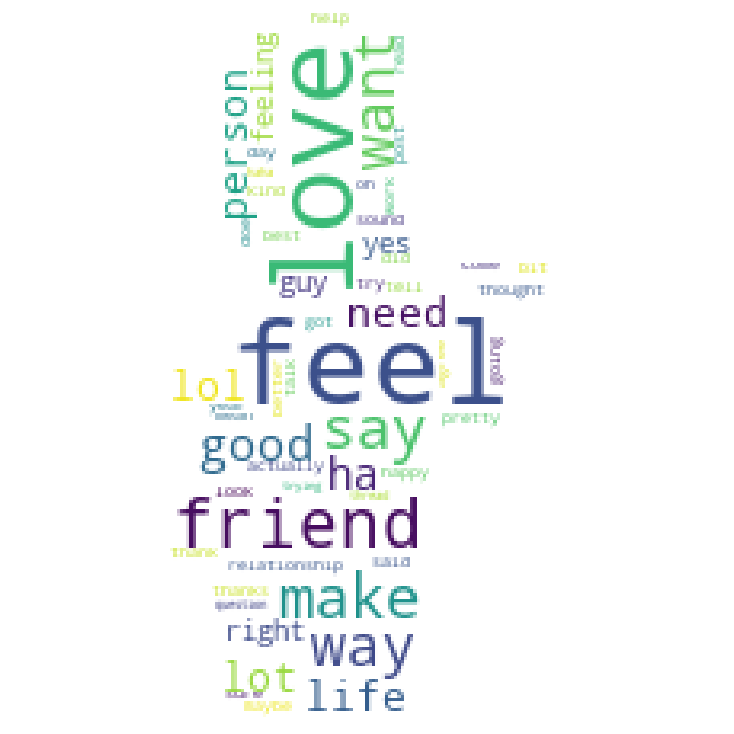

In [63]:
wordcloud = WordCloud(background_color='white',max_words=1000, max_font_size=200, random_state=42, mask=mask, width=800, height=1600)
wordcloud.generate_from_frequencies(frequencies=ENFJ)

plt.figure(figsize=(16,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()



ENFJ Word Cloud


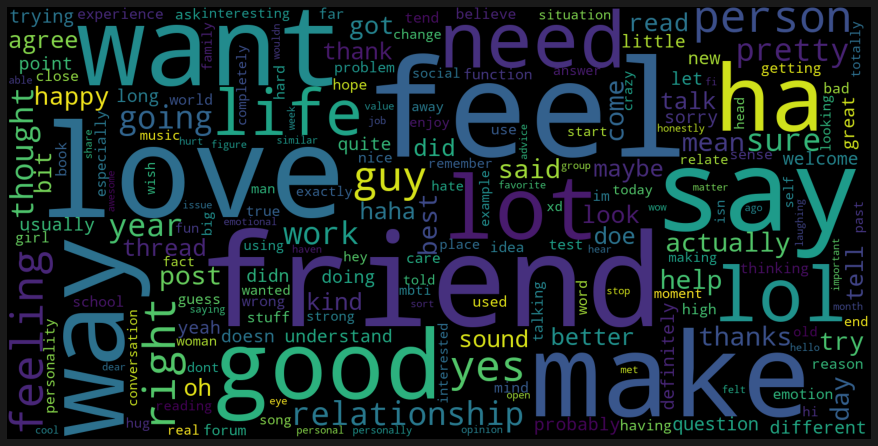



ENFP Word Cloud


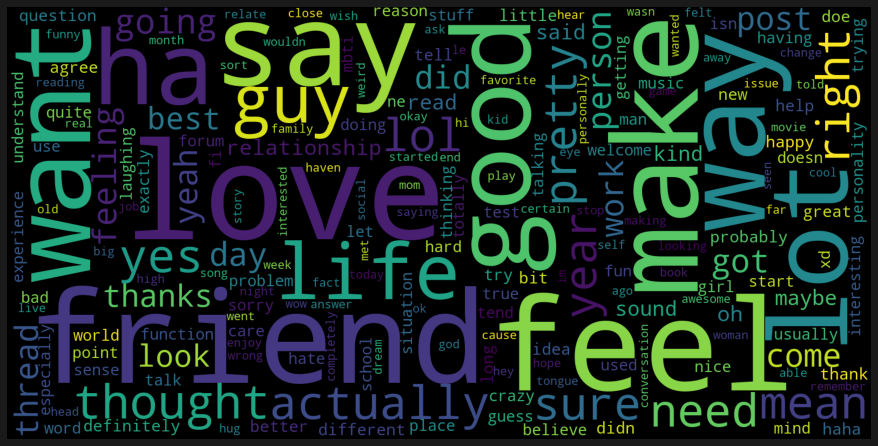



ENTJ Word Cloud


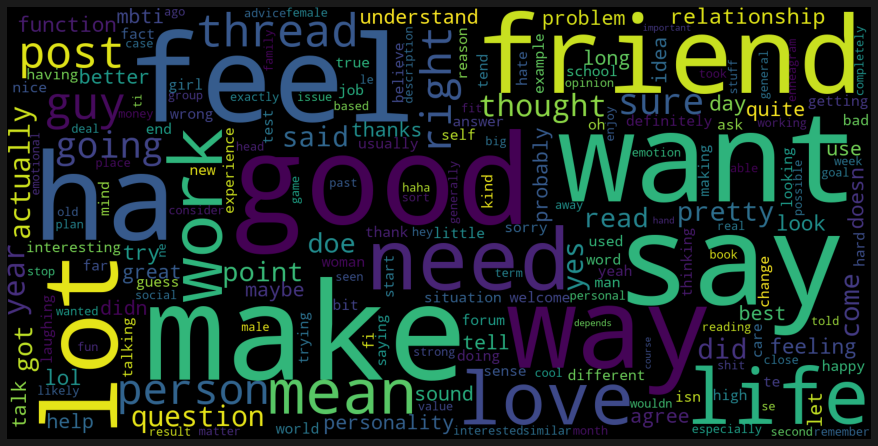



ENTP Word Cloud


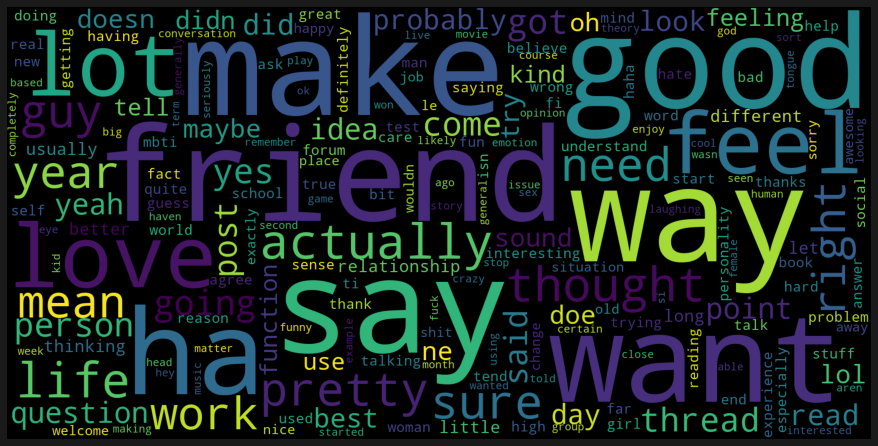



ESFJ Word Cloud


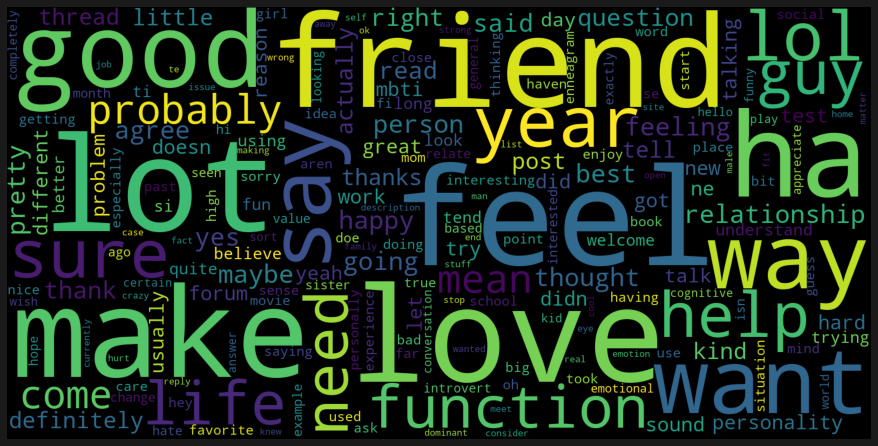



ESFP Word Cloud


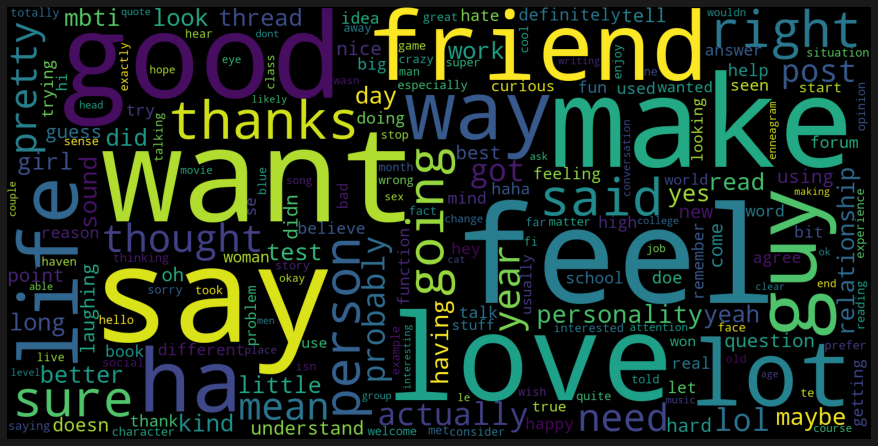



ESTJ Word Cloud


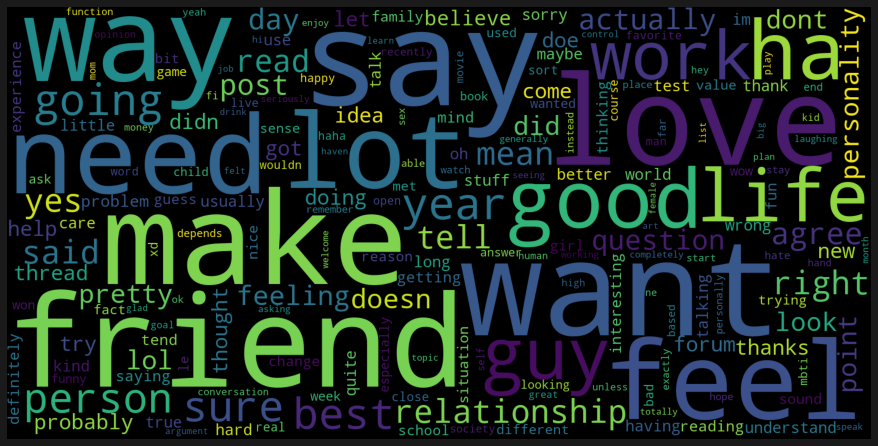



ESTP Word Cloud


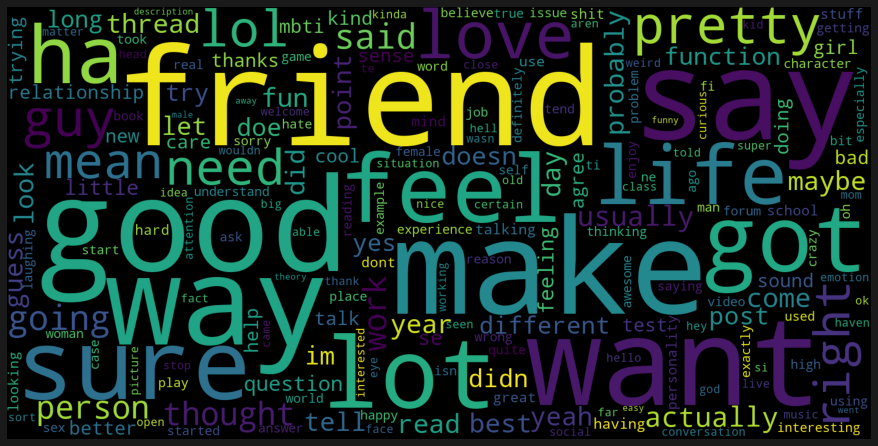



INFJ Word Cloud


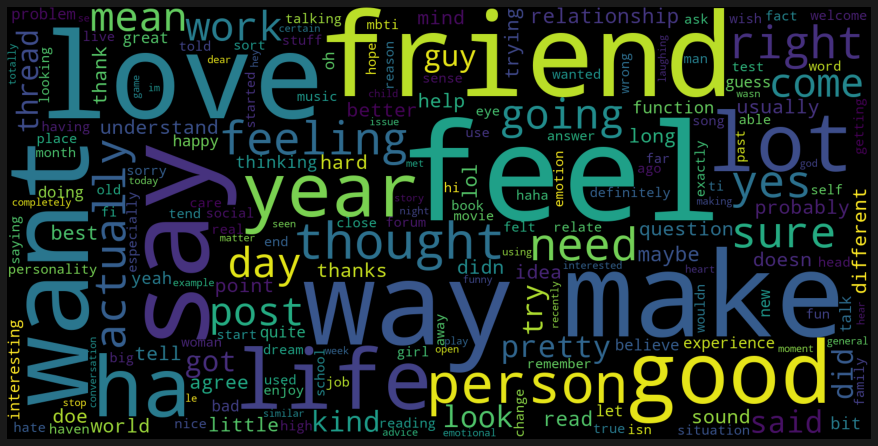



INFP Word Cloud


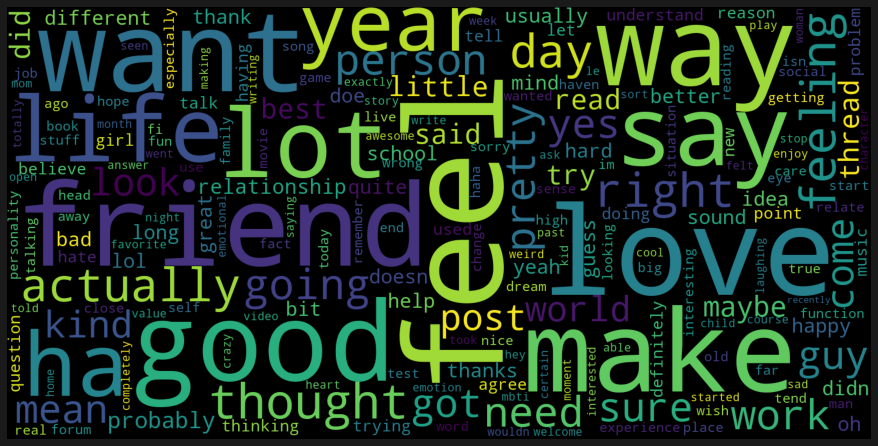



INTJ Word Cloud


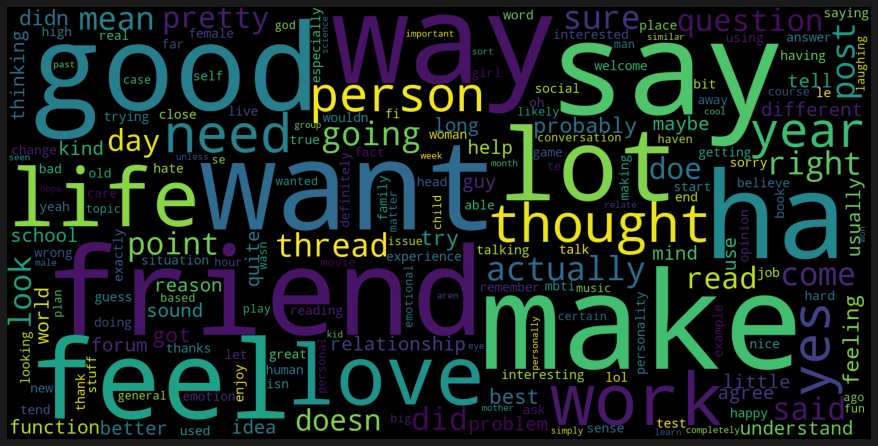



INTP Word Cloud


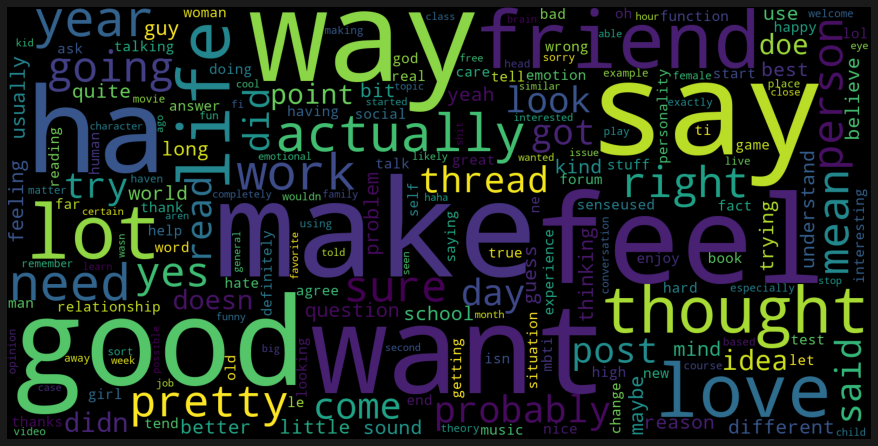



ISFJ Word Cloud


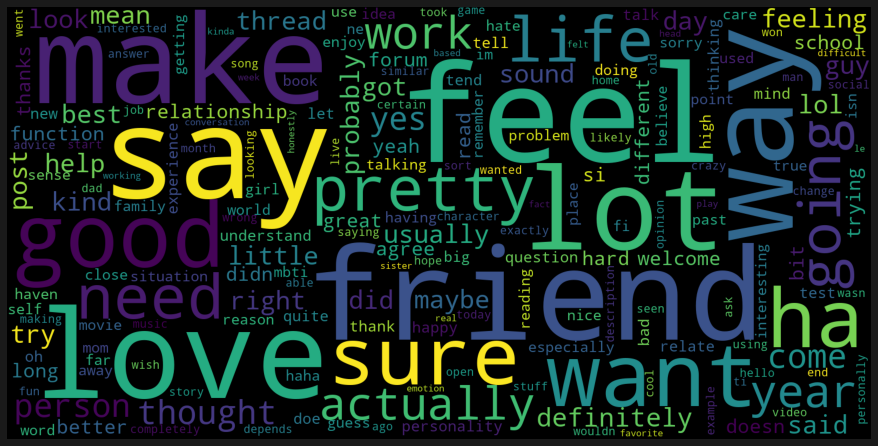



ISFP Word Cloud


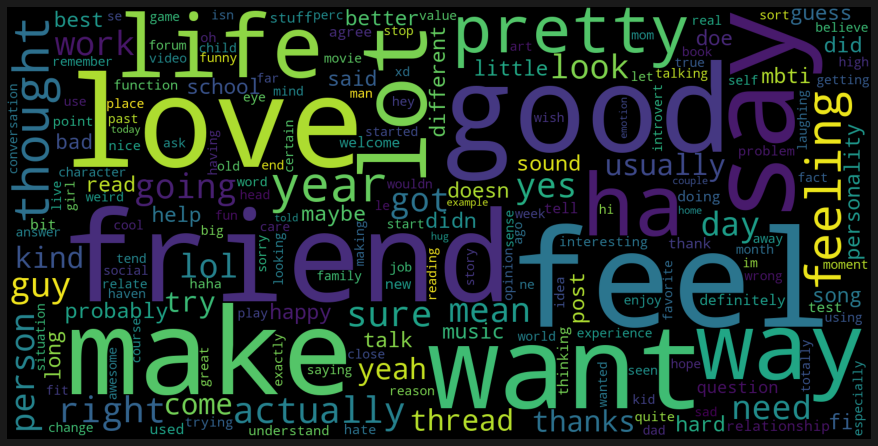



ISTJ Word Cloud


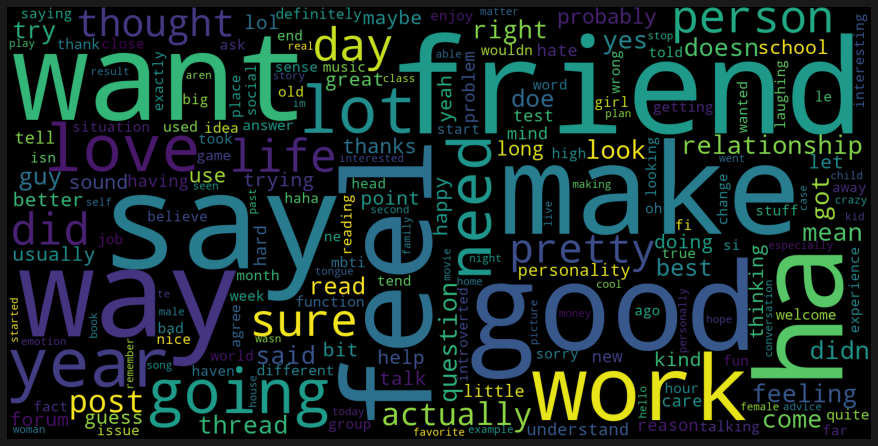



ISTP Word Cloud


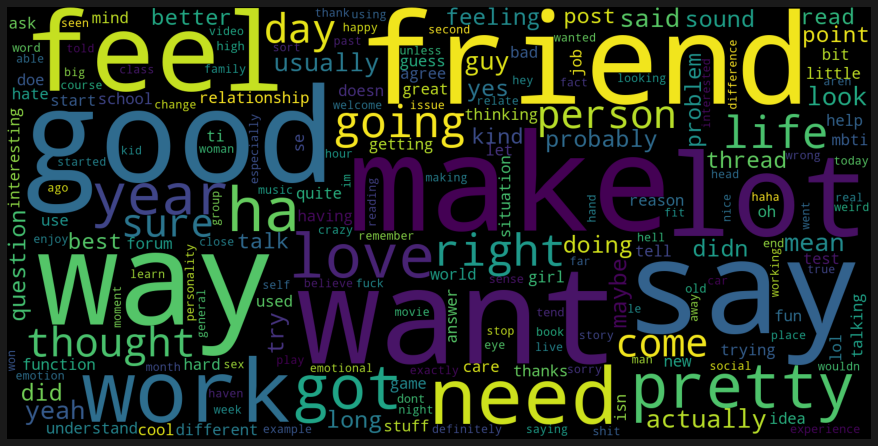

In [64]:
for mbti, dictionary in word_cloud_dict:
    wordcloud = WordCloud(max_font_size=250, width=1600, height=800).generate_from_frequencies(dictionary)
    
    print()
    print()
    print(mbti.upper() + ' Word Cloud')
    plt.figure( figsize=(12,8), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig('img/'+mbti.upper()+'_Word_Cloud.png', dpi=100)
    plt.show()

<a id=imbalanced></a>

<br>

## Dealing with Imbalanced Text Data

**PENDING SECTION**

[article](https://towardsdatascience.com/how-i-handled-imbalanced-text-data-ba9b757ab1d8)

In [65]:
df.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [66]:
## Function to find synonym of words 
import spacy
import en_core_web_sm # python -m spacy download en_core_web_sm 
from py_thesaurus import Thesaurus
import nltk 
from nltk.corpus import wordnet 
import random

nlp = en_core_web_sm.load()

<a id=model></a>

<br>

## First steps into Model Creation

<a id='train_test'></a>

### Train Test Split

I will try to replicate [this great notebook](https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb) by Emmanuel Ameisen

**I start by labeling the MBTI types so they are understood by the machine**

In [67]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
type_labels = df[['type']].apply(lambda x: le.fit_transform(x))
df.insert(1, 'type_label', type_labels)

# Print the head of the LabelEncoded categorical columns
df.head()

type  type_label                                              posts  I  J  \
0  INFJ           8  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...  1  1   
1  ENTP           3  'I'm finding the lack of me in these posts ver...  0  0   
2  INTP          11  'Good one  _____   https://www.youtube.com/wat...  1  0   
3  INTJ          10  'Dear INTP,   I enjoyed our conversation the o...  1  1   
4  ENTJ           2  'You're fired.|||That's another silly misconce...  0  1   

   N  T  NF  NT  SP  ...  sentence_count flesch_reading  \
0  1  0   1   0   0  ...              15          25.36   
1  1  1   0   1   0  ...              65          70.23   
2  1  1   0   1   0  ...              30          52.02   
3  1  1   0   1   0  ...              43          54.86   
4  1  1   0   1   0  ...              54          61.77   

  Flesch_Kincaid_Grade_Level  Fog_Scale  Automated_Readability  Coleman_Liau  \
0                       18.9      18.08                   31.6         20.43   
1                        7.9       8.98                   11.2          8.99   
2                       12.8      13.18                   17.4         11.03   
3                       11.7      12.89                   13.8          8.71   
4                        9.1      10.23                   12.5         10.55   

   Linsear_Write_Formula  Dale_Chall_Readability_Score  readability_consensus  \
0              11.333333                          9.00    18th and 19th grade   
1              12.400000                          6.53      8th and 9th grade   
2              11.600000                          7.45    12th and 13th grade   
3              13.000000                          7.34    11th and 12th grade   
4               6.555556                          7.26    10th and 11th grade   

                                   text_clean_joined  
0  and intj moment sportscenter not top ten play ...  
1  i m finding the lack of me in these post very ...  
2  good one course to which i say i know that s m...  
3  dear intp i enjoyed our conversation the other...  
4  you re fired that s another silly misconceptio...  

[5 rows x 25 columns]

<br>
<div class="span5 alert alert-danger">
    <p>After playing around with the code below I saw that 16 categories were too many. I decided to start small by only comparing 1 attribute which allows us to have only two groups.<p>
</div>

In [69]:
from sklearn.model_selection import train_test_split

list_corpus = df["text_clean_joined"].tolist()
list_labels = df["T"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)

<a id='cv'></a>

### Model with CountVectorizer

In [86]:
def cv(data):
    count_vectorizer = CountVectorizer(min_df=0.1, max_df=0.9, stop_words=stop_words)

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer


X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [87]:
print(len(X_train_counts.todense()))
print(len(count_vectorizer.get_feature_names()))

6940
725


**Note to self:** including all the words apparently has a positive effect in accuracy, recall, and precision. I think this is due to the MBTI types themselves. Taking them out I think is a good idea since it will generalize better to other contexts where people do not use these kind of terms.

<br>

**Visualizing the embeddings**

Now that we've created embeddings, let's visualize them and see if we can identify some structure. In a perfect world, our embeddings would be so distinct that are two classes would be perfectly separated. Since visualizing data in 296 dimensions is hard, let's project it down to 2. For this Ameisen uses Principal Component Analysis


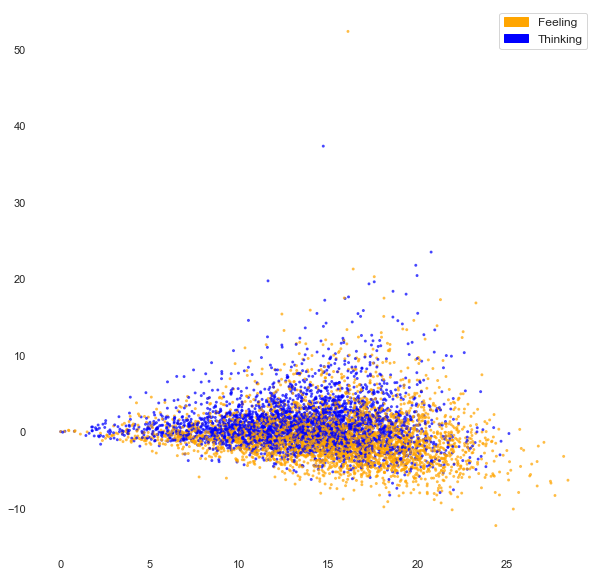

In [88]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=4, alpha=.6, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Feeling')
            blue_patch = mpatches.Patch(color='blue', label='Thinking')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 12})

fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.savefig('img/CountVectorizer_Feeling_Thinking.png', dpi=100, transparent=True)
plt.show()

<br>

**Fitting a classifier**

Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.


In [89]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

<br>

**Evaluation**

Let's start by looking at some metrics to see if our classifier performed well at all.

In [90]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.742, precision = 0.742, recall = 0.742, f1 = 0.742


<br>

**Inspection**

A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.


In [91]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20, pad=30)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15, labelpad=15)
    plt.xlabel('Predicted label', fontsize=15, labelpad=30)

    return plt

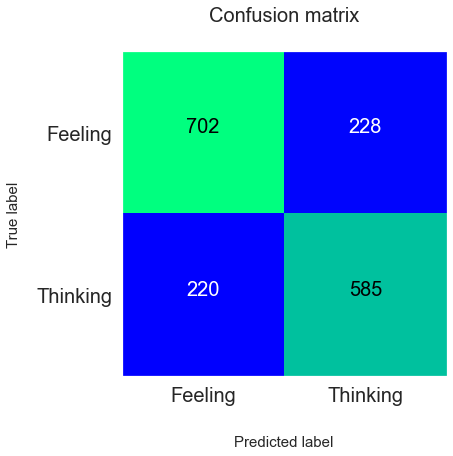

In [92]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm, classes=['Feeling','Thinking'], normalize=False, title='Confusion matrix')
plt.savefig('img/CountVectorizer_Feeling_Thinking_cm.png', dpi=100, transparent=True)
plt.show()
#print(cm)

<br>

**Further inspection**

Let's look at the features our classifier is using to make decisions.

In [93]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

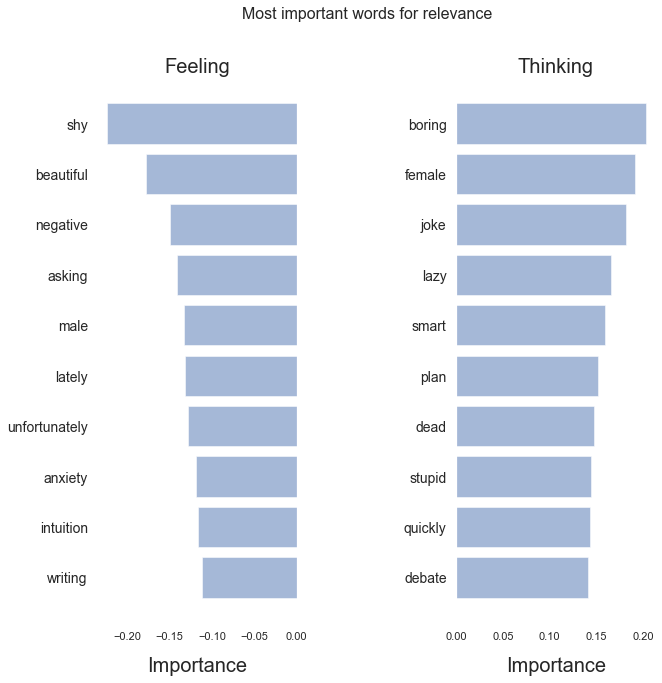

In [94]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name, save_as):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Feeling', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20, labelpad=15)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Thinking', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20, labelpad=15)
    
    plt.subplots_adjust(wspace=0.8)
    plt.savefig(save_as, dpi=100, transparent=True)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance",
                    save_as='img/CountVectorizer_Feeling_Thinking_features.png')


<a id='tf'></a>

### Model with TF-IDF

Let's try a slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.


In [95]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

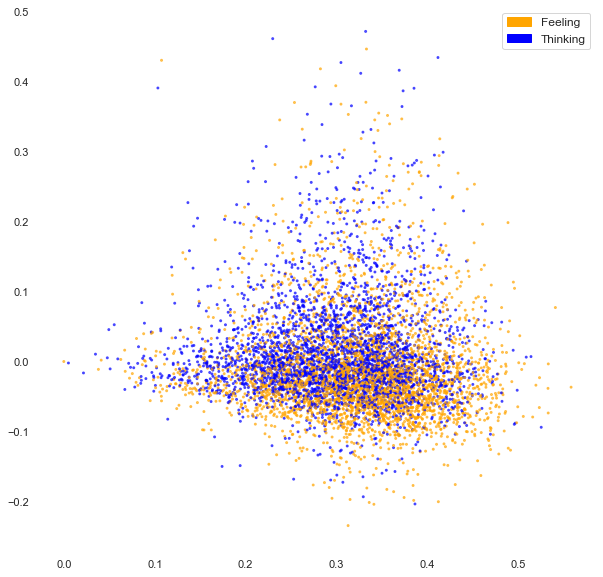

In [96]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.savefig('img/TF_IDF_Feeling_Thinking.png', dpi=100, transparent=True)
plt.show()

In [97]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [98]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.795, precision = 0.795, recall = 0.795, f1 = 0.794


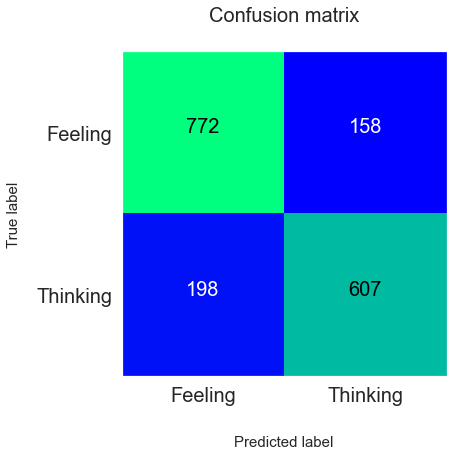

TFIDF confusion matrix
[[772 158]
 [198 607]]
BoW confusion matrix
[[702 228]
 [220 585]]


In [99]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm2, classes=['Feeling','Thinking'], normalize=False, title='Confusion matrix')
plt.savefig('img/TF_IDF_Feeling_Thinking_cm.png', dpi=100, transparent=True)
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

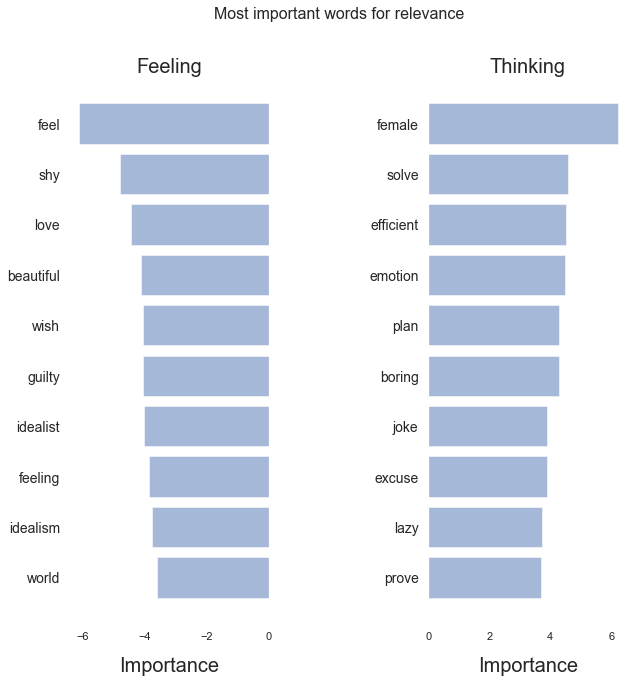

In [100]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance", 
                    save_as='img/TF_IDF_Feeling_Thinking_features.png')

<a id='wv'></a>

### Model with Word2Vec

<br>

**Capturing semantic meaning**

Our first models have managed to pick up on high signal words. However, it is unlikely that we will have a training set containing all relevant words. To solve this problem, we need to capture the semantic meaning of words. Meaning we need to understand that words like 'good' and 'positive' are closer than apricot and 'continent'.

**Enter word2vec**

Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [102]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=2000000)

In [103]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = df['text_clean'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [104]:
embeddings = get_word2vec_embeddings(word2vec, df)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

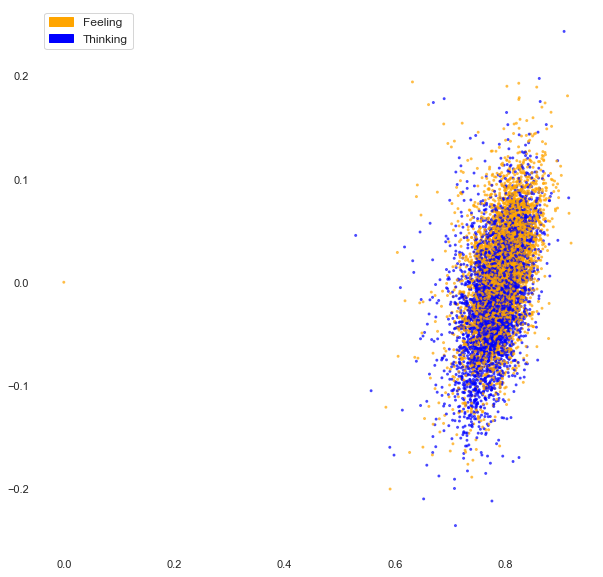

In [105]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.savefig('img/Word2Vec_Feeling_Thinking.png', dpi=100, transparent=True)
plt.show()

In [106]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [107]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.787, precision = 0.787, recall = 0.787, f1 = 0.787


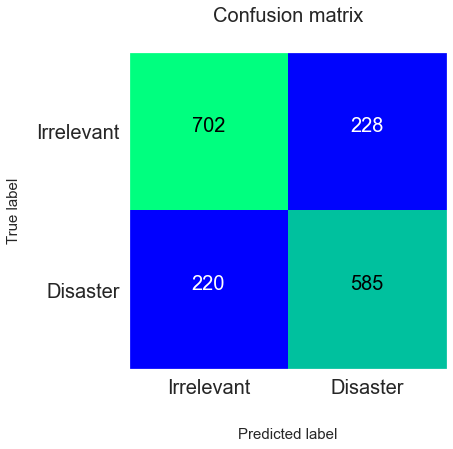

Word2Vec confusion matrix
[[735 195]
 [175 630]]

TFIDF confusion matrix
[[772 158]
 [198 607]]

BoW confusion matrix
[[702 228]
 [220 585]]


In [108]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(6, 6))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix')
plt.savefig('img/Word2Vec_Feeling_Thinking_cm.png', dpi=100, transparent=True)
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print()
print("TFIDF confusion matrix")
print(cm2)
print()
print("BoW confusion matrix")
print(cm)

<br>

Emmanuel also uses CNNs (Convolutional Neural Networks) for text classification but for the time being I will leave it here. I need to process what I learned up to now. In our first models it seems that the TFIDF did the best in labeling mbti type `Thinking` and `Feeling`, we could also load more words from the `GoogleNews-vectors-negative300.bin.gz` pretrained model. Maybe it helps boost the Word2Vec predictive power since it includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset.